# Car Brand Associations Report
### Unsturctured Data Analytics - HW1
Members:  
* Satya
* A.J. 
* Jake Johnson
* Sam Worley

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud
stop_words = set( stopwords.words("english") )
import nltk
from collections import Counter
from sklearn import manifold
import matplotlib.pyplot as plt

## Section 1: Gather Data
For this assignment which is designed to study which brands ... TODO ... we chose to scrape an Edmunds forum .... mention something about date and time ... provide link to forum ... TODO

In [2]:
# 
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

wd = webdriver.Chrome("chromedriver", options=chrome_options)

link = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p'
comments = pd.DataFrame(columns= ['UserID', 'Date', 'Comments'] )

for page in range(1,101):
    wd.get(link + str(page))

    ids = wd.find_elements_by_xpath("//*[contains(@id,'Comment_')]")

    comment_ids = []
    
    for i in ids:
      comment_ids.append(i.get_attribute('id'))
    

    for j in comment_ids:
        #Extract dates from for each user on a page
        user_date = wd.find_elements_by_xpath('//*[@id="' + j +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
        date = user_date.get_attribute('title')

        #Extract user ids from each user on a page
        userid_element = wd.find_elements_by_xpath('//*[@id="' + j +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
        userid = userid_element.text

        #Extract Message for each user on a page
        user_message = wd.find_elements_by_xpath('//*[@id="' + j +'"]/div/div[3]/div/div[1]')[0]
        comment = user_message.text
                                      
        #Adding date, userid and comment for each user in a dataframe    
        comments.loc[len(comments)] = [date,userid,comment]
  

WebDriverException: Message: 'chromedriver' executable needs to be in PATH. Please see https://sites.google.com/a/chromium.org/chromedriver/home


In [2]:
# Read in from .csv for work offline
comments = pd.read_csv("comments.csv")
print(len(comments))
comments["Comments"].describe()

comments.dropna(inplace=True)
print(len(comments))

5000
4986


## Task A
Once you fetch the data, test if the data support Zipf’s law. Plot the most common 100 words in the data against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization. Hint: Check http://www.garysieling.com/blog/exploring-zipfs-law-with-python-nltk-scipy-and-matplotlib


In [8]:
comments_zl = comments.copy()
comments_zl["Comments"] = comments_zl["Comments"].str.lower()
comments_zl["Comments"] = comments_zl["Comments"].str.strip()

In [9]:
val = Counter(" ".join(comments_zl["Comments"].str.lower()).split()).most_common(100)
most_common_stop = pd.DataFrame(val)
most_common_stop.columns = ["Word", "Frequency"]
most_common_stop[:10]

,Word,Frequency
0,the,26535
1,a,12010
2,and,10464
3,i,10051
4,to,9812
5,is,7551
6,of,7093
7,in,6615
8,that,5634
9,it,4707


In [10]:
most_common_stop["Rank"] = most_common_stop.index + 1
most_common_stop.head()

,Word,Frequency,Rank
0,the,26535,1
1,a,12010,2
2,and,10464,3
3,i,10051,4
4,to,9812,5


In [11]:
data = {'Rank': range(1,101)}
zipf = pd.DataFrame(data=data)
zipf["Count"] = most_common_stop['Frequency'].max()/zipf['Rank']
zipf.head()

,Rank,Count
0,1,26535.00
1,2,13267.50
2,3,8845.00
3,4,6633.75
4,5,5307.00


Text(0.5, 1.0, "Proof of Zipf's Law")

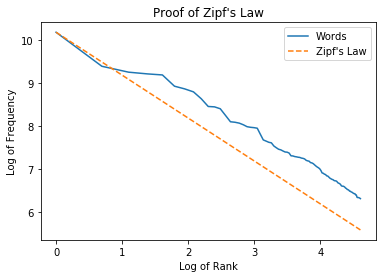

In [26]:
plt.plot(np.log(most_common_stop['Rank']), np.log(most_common_stop['Frequency']), marker='None', linestyle='-', label='Words')
plt.plot(np.log(zipf['Rank']), np.log(zipf['Count']), marker='None', linestyle='--', label="Zipf's Law")

plt.xlabel('Log of Rank')
plt.ylabel('Log of Frequency')
plt.legend(loc = 'best')
plt.title("Proof of Zipf's Law")

Here we see a releatively constant linear relationship between frequency of a word on the y axis and log of rank on the x axis to support that there is in fact some constant, ($k$) which satisfies that $rank * frequency = k$. $k$ is seen in the slope of this graph. And appears relatively stable and constant except for the minor jump between log of 1 and log of 2.  

## Task B
Find the top 10 brands from frequency counts. You will need to write a script to count the frequencies of words (stopwords should NOT be counted). Replace frequentl occcuring car models with brands so that from now on you have to deal with only brands and not models. You will need another script for this job. A list of model and brand names (not exhaustive) are provided in a seperate file. 

In [27]:
# Count Frequencies with stopwords
def get_word_frequencies(data, text_col, include_stopwords=False):
    
    stop_words = stopwords.words("english") 
    
    if include_stopwords:
        all_words = [word.lower() for text in data[text_col] for word in text.split()]
    else:
        all_words = [word.lower() for text in data[text_col] for word in text.split() if word.lower() not in stop_words]
    bow_words = {}
    for word in all_words:
        if word in bow_words:
            bow_words[word] += 1 
        else:
            bow_words[word] = 1
            
    df = pd.DataFrame.from_dict(bow_words, orient="index", columns=["Frequency"])#.reset_index()#.rename({"index":"Word"},axis=1)
    return df.reset_index().rename({"index":"Word"},axis=1).sort_values(by = "Frequency", ascending=False)

In [46]:
def generate_wordcloud(data, text_col):
    '''TODO'''
    text = ' '.join( data[text_col] ) 
    
    text = ' '.join( [word for word in text.split() if word not in stop_words]) # remove stop words
    
    wc = WordCloud(width=500, height=500, background_color="white").generate(text)

    # display the generated image:
    my_dpi = 72
    plt.figure(figsize = (500/my_dpi, 500/my_dpi), dpi=my_dpi)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    
    return plt


with_stop_words = get_word_frequencies(comments, "Comments", include_stopwords=True)

In [32]:
word_freqs = get_word_frequencies(comments, "Comments", include_stopwords=False )

brands = set( ["bmw", "audi", "volvo", "lexus", "hundai", "honda", "toyota",
            "ford", "chevy", "lincoln", "mercedes", "nissan", "chevrolet",
         "cadillac", "volkswagen", "infiniti", "subaru", "chryseler", 
         "jeep", "buick", "kia", "volvo", "porsche", "acura"])

top_brands = word_freqs[ word_freqs["Word"].isin( brands ) ]

top_10_brands = top_brands[:10]

#sns.barplot(x = "Frequency", y = "Word", data=top_brands)
print("Top brands and frequency before replacement")
top_10_brands.rename({"Word":"Brand"}, axis=1).set_index("Brand")

Top brands and frequency before replacement


,Frequency
Brand,
bmw,1466
acura,431
infiniti,381
lexus,374
audi,263
nissan,185
honda,183
mercedes,135
volvo,129


In [33]:
## Replacement
car_brands_df = pd.read_csv("car models and brands.csv")
print("Length of car models and brands", len(car_brands_df))
car_brands_df.set_index("Model", inplace = True)
print("New Length", len(car_brands_df))

#print( car_brands_df[:5] ) 

Length of car models and brands 536
New Length 536


In [34]:
# Find and Replace
def find_replace_helper(text, replace_dict, replace_col = None):
    '''
    Inputs:
        * text -> text to edit
        * replace_dict -> python Dictionary or pandas dataframe to look up replacement values
        * replace_col -> if using a pandas Dataframe the column to look at to get the new value. Default is None
    '''
    if type(replace_dict) == dict:
        for key in replace_dict.keys():
            if key.lower() in text.lower():
                # do replacement
                idx_replace_idx = text.lower().index( key.lower() )
                beg = text[:idx_replace_idx]
            
                end = text[idx_replace_idx + len(key) : ]
            
                text =  beg + replace_dict[key] + end
            
        return text
    
    elif type(replace_dict) == pd.core.frame.DataFrame: # If referencing a dataframe
        for key in replace_dict.index: # Loop through pandas dataframe index
            if key.lower() in text.lower():
                # build unreplace part of sentence
                idx_replace_idx = text.lower().index( key.lower() )
                beg = text[:idx_replace_idx]
                end = text[idx_replace_idx + len(key) : ]
                
                # Look up replacement
                if (replace_col != None): # replace_col is an actual arguement. This is the ideal functionality
                    replace_word = replace_dict.loc[key][replace_col]
                    if (type(replace_word) != str):
                        replace_word = replace_word[0]

                else: # replace_col not passed an we have to guess. Not ideal. Only works for dataframe with index and single column
                    replace_word = replace_dict.loc[key]
                    if len(replace_word) == 1:
                        replace_word = replace_word[0]
                    else:
                        replace_word = replace_word.iloc[0][0]  
                # put text back together
                text =  beg + replace_word + end
        
        return text
    
    else:
        print("Error: Replace_Dict not of right type\n must be a Python dictionary or pandas.core.frame.DataFrame")
        

        
def find_replace(data, text_col, replace_dict, replace_col = None):
    '''
    Function to handle find and replace.
    replace_dict should be a dictionary with key equal to original word
    and value equal to replacement
    Replace_col is column to get value from off the index
    '''
    if (type(replace_dict) == dict) or (type(replace_dict) == pd.core.frame.DataFrame): 
        data[text_col] = data[text_col].map(lambda x: find_replace_helper(x, replace_dict, replace_col))
    else:
        print("Returning None\nreplace_dict in find_replace not of correct type\nMust be Python Dictionary or pandas.core.frame.DataFrame")
    
    return data

In [36]:
replacement_comments = find_replace(comments, "Comments", car_brands_df)
#replacement_comments["Comments"][1]
replacement_wfs = get_word_frequencies(replacement_comments, "Comments", include_stopwords=False)
top_brands_2 = replacement_wfs[replacement_wfs["Word"].isin(brands)]
print("Top brands after replacement")
top_brands_2 = top_brands_2.rename({"Word":"Brand"}, axis=1).set_index("Brand")[:10]
top_brands_2

Top brands after replacement


,Frequency
Brand,
bmw,2280
acura,686
audi,575
mercedes,540
lexus,540
honda,462
infiniti,440
nissan,345
subaru,289


## Task C
Calculate lift ratios for associations between the top-10 brands identified in Task A. You will have to write a script to do this task). For lift calculations, be sure not to count a mention more than once per post, even if it is mentioned multiple times in the post.

In [37]:
# Helper Functions
def text_contains_indicator( text, *args):
    '''Function returns 1 if all given strings passed in *args
    are present within the text, else returns 0'''
    text = text.lower() # lower the text first to get make processing consistent
    
    # Check input that at least 1 word was given in args
    if len(args) == 0:
        print("Error occurred")
        
    if len(args) >= 3:
        print("Error occured in text_contains_indicator\nmore than 2 words passed")
        
    for word in args: # Loop through each arguement
        word = str(word)
        word = word.lower() # lower case the current word to make it consistent with text
        if word not in text:
            return 0
    
    return 1
        
    
def compute_lift(data, text_col, word_1, word_2):
    '''Function to return a numeric value of lift for two given words'''
    data = data.copy() 
    
    if word_1 == word_2:
        return 0
    
    data["A"] = data[text_col].map(lambda x: text_contains_indicator(x, word_1))
    data["B"] = data[text_col].map(lambda x: text_contains_indicator(x, word_2))
    data["comentions"] = data[text_col].map(lambda x: text_contains_indicator(x, word_1, word_2))
    
    #print(data)
    
    a_mentions = sum(data["A"])
    b_mentions = sum(data["B"])
    comentions = sum(data["comentions"])
    N = len(data[text_col])
    
    #print(a_mentions)
    #print(b_mentions)
    #print(comentions)
    #print(N)
    
    return (N * comentions) / (a_mentions * b_mentions)

def build_matrix(attributes):
    '''Function Builds a symmetric pandas.DataFrame where the index is the attributes,
    and the columns are attributes as well. Sets the cell value to 0.0 to begin'''
    
    matrix = {key:[0.0] * len(attributes) for key in attributes}
    matrix["Index"] = attributes
    matrix = pd.DataFrame(matrix)
    matrix.set_index("Index", inplace = True)
    
    return matrix

def lift_main(data, text_col, attributes):
    '''Main function to caluclate lift of all attributes and generate a matrix of lift values'''
    
    matrix = build_matrix(attributes)

    #matrix.set_index("Index", inplace=True)
    for row in matrix.index: # iterate through each row
        matrix.loc[row]
        for col in matrix.columns: # iterate through each column 
            matrix.loc[row][col] = compute_lift(data, text_col, row, col) # assign lift
            
    return matrix

def dissimilarity_matrix(matrix, no_lift_thresh = 5):
    '''transform a given similarity matrix to a dissimilarity matrix'''
    matrix_2 = matrix.copy()
    for col in matrix_2.columns:
        matrix_2[col] = matrix_2[col].map(lambda x: 1 / x if x > 0 else no_lift_thresh)
        
    return matrix_2
    


#### CONFIGURATION
#attributes = ["bmw", "lexus", "infiniti", 'honda', 'audi', 'handling', 'performance', 'transmission', 'luxury']

matrix = lift_main(comments, "Comments", top_brands_2.index.tolist())
print("Lift Ratio Table")
matrix

Lift Ratio Table


,bmw,acura,audi,mercedes,lexus,honda,infiniti,nissan,subaru,toyota
Index,,,,,,,,,,
bmw,0.000000,1.437852,1.639455,1.770754,1.801929,1.288216,1.922145,1.237909,1.222581,1.259378
acura,1.437852,0.000000,2.094320,2.003034,2.728757,2.389363,2.878709,2.062095,1.838588,1.425180
audi,1.639455,2.094320,0.000000,3.287406,2.392447,1.308279,2.474430,1.513146,1.639310,1.415235
mercedes,1.770754,2.003034,3.287406,0.000000,3.213776,1.625013,2.392612,1.577973,1.264712,1.428719
lexus,1.801929,2.728757,2.392447,3.213776,0.000000,1.510576,3.312517,1.545429,1.606718,1.620860
honda,1.288216,2.389363,1.308279,1.625013,1.510576,0.000000,1.462712,2.791153,1.466321,1.742433
infiniti,1.922145,2.878709,2.474430,2.392612,3.312517,1.462712,0.000000,2.640500,1.791476,1.355892
nissan,1.237909,2.062095,1.513146,1.577973,1.545429,2.791153,2.640500,0.000000,1.627285,1.556634
subaru,1.222581,1.838588,1.639310,1.264712,1.606718,1.466321,1.791476,1.627285,0.000000,1.261471


## Task D
Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there
are multiple scripts available on GitHub).

<module 'matplotlib.pyplot' from '/Users/samworley/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

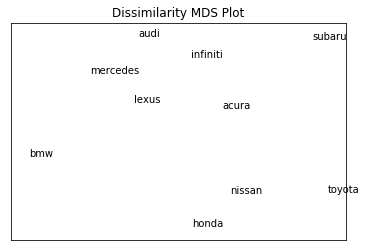

In [42]:
def generate_MDS_plot(matrix_df, random_state = 48):
    matrix_df = matrix_df.copy()
    
    mds_model = manifold.MDS(n_components = 2, random_state = random_state,
    dissimilarity = "precomputed")

    labels = [str(label) for label in list(matrix_df.index)]

    mds_fit = mds_model.fit(matrix_df)
    coords = mds_fit.embedding_

    plt.figure()
    plt.scatter(coords[:,0], coords[:,1], facecolors = "none")

    for label, x, y in zip(labels, coords[:,0], coords[:,1]):
        plt.annotate(label, (x,y), xycoords = 'data')
        
        
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.grid(True)
    plt.title("Dissimilarity MDS Plot")
    
    
    return plt


diss_matrix = dissimilarity_matrix(matrix) # get the dissimilarty matrix for plotting MDS
generate_MDS_plot(diss_matrix, random_state = 43) # use the random state to tweak the display while preserving the relationships


## Task E
What insights can you offer to your client from your analyses in Tasks C and D?   

First off, it is really surprising that subaru and toyota even made the cut in the top 10 most mentioned car brands of a luxury forum. Based on the plot here it looks like there are relatively 3 different groupings or sections. We have a cluster in the top middle, the Audi, Mercedes, Infiniti, Lexus, and Acura group, then a cluster of nissan & honda, and then it looks like two outliers of toyota and subaru. And what this seems to indicate is the Subaru and Toyota are on the fringes of the luxury car conversation. This likely means that Subaru and Toyota ride the boundry between luxury and non-luxury cars. A brand manager can use this information in his targeting strategy for acquiring new customers because they can assume they 

Target subaru and toyota customers because they may take the smallest jump to get into luxury car brands compared to other non-luxury brands. The Subaru drivers may be the ones on the cusp of entering the luxury car demographic for the first time and a valuable place to search for first time luxury car buyers. This strategy is well suited for Nissan, Honda, Acura, & Infiniti but not for brands like Lexus, Mercedes, or BMW. However, if you are a brand manager for Acura, and care more about the luxurious brand image and less about first time luxury car buyers, you need to start comparing your brand to BMW, Mercedes, and Lexus to move yourself away from the less luxurios brands. 

On the other hand, if you are a brand manager for Toyota or Subaru you can do the opposite and target the nearest brands of Acura & Nissan. This allows you to go after brands known for, at least slightly, luxury and maybe sway buyers who want a different set of trade-offs, say performance on different terrain, but still have a luxury feel.    



## Task F
* What are 5 most frequently mentioned attributes or features of cars in the discussions? 
* Which attributes are most strongly associated with which of these 5 brands? You DON’T have to do a sentiment analysis for this assignment.

<module 'matplotlib.pyplot' from '/Users/samworley/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

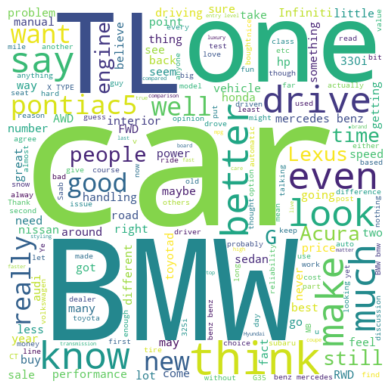

In [47]:
tmp = get_word_frequencies( replacement_comments, text_col="Comments", include_stopwords=False)
tmp.to_csv("word_frequencies.csv") # Look through the data manually 
generate_wordcloud(replacement_comments, "Comments") # Plot data in word cloud for quick viewing. 

[Text(0.5, 1.0, 'Frequency of top 5 Attributes')]

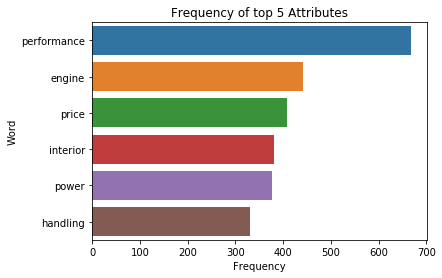

In [55]:
observed_attributes = ["handling", "performance", "interior", "power", "engine", "price"]
# ^ set came from word_frequencies.csv
sns.barplot(x = "Frequency", y = "Word", data=tmp[tmp["Word"].isin(observed_attributes)]).set(title="Frequency of top 5 Attributes")

Here we see that the most commonly mentioned attributes are:
* Performance
* Engine
* Price
* Interior
* Power


In [60]:
# Filter our brands to only look at top 5
new_lift_words = ["performance","handling","price", "interior", "power"] + top_brands_2[:5].index.tolist()
# Print new phrases to calc lift for:
new_lift_words

['performance',
 'handling',
 'price',
 'interior',
 'power',
 'bmw',
 'acura',
 'audi',
 'mercedes',
 'lexus']

In [61]:
matrix = lift_main(replacement_comments, "Comments", new_lift_words)
print("Lift Association Ratio Table: Brands & Attributes")
matrix

Lift Association Ratio Table: Brands & Attributes


,performance,handling,price,interior,power,bmw,acura,audi,mercedes,lexus
Index,,,,,,,,,,
performance,0.000000,2.301204,1.785712,1.568133,1.817544,1.502048,1.428304,1.439893,1.162479,1.591716
handling,2.301204,0.000000,1.667058,3.132883,2.583420,1.662781,1.517690,1.437871,1.263478,1.419188
price,1.785712,1.667058,0.000000,2.305985,1.800978,1.557579,1.500181,1.914106,1.479424,1.710233
interior,1.568133,3.132883,2.305985,0.000000,2.003760,1.270430,1.546903,2.297326,1.076231,1.889721
power,1.817544,2.583420,1.800978,2.003760,0.000000,1.482509,1.763615,1.812018,1.565709,1.628715
bmw,1.502048,1.662781,1.557579,1.270430,1.482509,0.000000,1.437852,1.639455,1.770754,1.801929
acura,1.428304,1.517690,1.500181,1.546903,1.763615,1.437852,0.000000,2.094320,2.003034,2.728757
audi,1.439893,1.437871,1.914106,2.297326,1.812018,1.639455,2.094320,0.000000,3.287406,2.392447
mercedes,1.162479,1.263478,1.479424,1.076231,1.565709,1.770754,2.003034,3.287406,0.000000,3.213776


<module 'matplotlib.pyplot' from '/Users/samworley/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

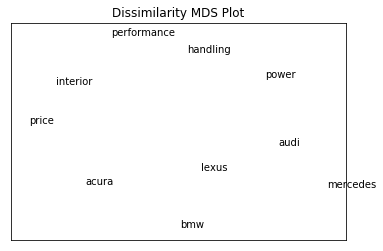

In [63]:
diss_matrix = dissimilarity_matrix(matrix)
generate_MDS_plot(diss_matrix)

**Task G:** What advice will you give to your client from Task F? For this assignment, you can assume that all sentiments are positive.   

TODO   


**Task H:** Which is the most aspirational brand in your data in terms of people actually wanting to buy
or own? Describe your analysis. What are the business implications for this brand?  

The process here is to use lift analysis and find which brands have the highest association to 'aspriational' type words like "want", "desire", "wish". To do this we will do find and replace on these words to change them all to the same word and find which brands then have the highest lift with the new aspirational marker we put in the text. 



In [269]:
# Find and replace on new dictionary of terms
aspirational_dict = {
    "want":"aspiration",
    "wish":"aspiration",
    "wish":"aspiration",
    "desire":"aspiration",
    "i want":"aspiration",
    "i'm looking to":"aspiration",
    "i will":"aspiration", 
    "i'm going to":'aspiration'
                    }


aspiration_comments = find_replace(comments, 'Comments', aspirational_dict)

asp_wf = get_word_frequencies(aspiration_comments, "Comments", include_stopwords=False)

print(f"The word `aspiration` now occurs {asp_wf.set_index('Word').loc['aspiration'][0]} times")

The word `aspiration` now occurs 886 times


In [272]:
# Perform Lift Analysis and get new lift table
lift = lift_main(aspiration_comments, "Comments", ["bmw", "acura", "audi", "lexus", "mercedes", "aspiration"])
print("Lift Ratio Table: Top 5 brands and Aspiration")
lift

Lift Ratio Table: Top 5 brands and Aspiration


,bmw,acura,audi,lexus,mercedes,aspiration
Index,,,,,,
bmw,0.000000,1.437852,1.639455,1.801929,1.770754,1.453767
acura,1.437852,0.000000,2.094320,2.728757,2.003034,1.378844
audi,1.639455,2.094320,0.000000,2.392447,3.287406,1.502723
lexus,1.801929,2.728757,2.392447,0.000000,3.213776,1.497510
mercedes,1.770754,2.003034,3.287406,3.213776,0.000000,1.356596
aspiration,1.453767,1.378844,1.502723,1.497510,1.356596,0.000000
